In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

# 시계열(Time Series) 생성

In [236]:
# 종가와 최고가, 최저가를 모두 예측하자
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df_close = df["Close"]
df_high = df["High"]
df_low = df["Low"]
df_close.head(10)

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
2020-05-25    48850.0
2020-05-26    49250.0
2020-05-27    49900.0
2020-05-28    50400.0
2020-05-29    50700.0
Name: Close, dtype: float64

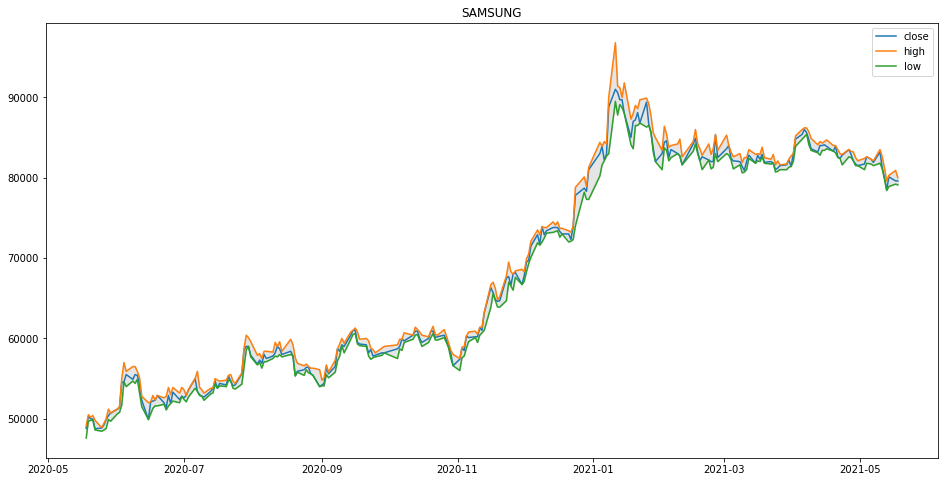

In [237]:
plt.figure(figsize = (16,8))
plt.plot(df_close,label = "close"); plt.plot(df_high,label = "high"); plt.plot(df_low,label = "low")
plt.fill_between(df_close.index, df_low, df_high, color='k', alpha=.10)
plt.title("SAMSUNG")
plt.legend()

# 시계열 안정성의 정성적 분석

In [238]:
# 결측치 여부 확인
print(df_close[df_close.isna()])
print(df_high[df_high.isna()])
print(df_low[df_low.isna()])


Series([], Name: Close, dtype: float64)
Series([], Name: High, dtype: float64)
Series([], Name: Low, dtype: float64)


* 결측치는 모두 없다.

In [239]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

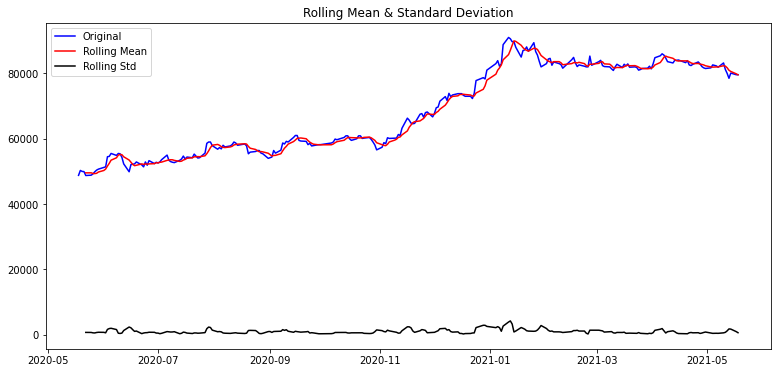

In [240]:
plot_rolling_statistics(df_close, window=5)

# Augmented Dickey-Fuller Test(ADF Test) 

>1. 주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(Null Hypothesis)를 세운 후,
2. 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에
3. 이 시계열 데이터가 안정적이다라는 대립가설(Alternative Hypothesis)을 채택한다는 내용입니다.

## statsmodels 패키지와 adfuller 메소드
 R에서 제공하는 통계검정, 시계열분석 등의 기능을 파이썬에서도 이용할 수 있도록 하는 강력한 통계 패키지

In [241]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [242]:
augmented_dickey_fuller_test(df_close)
print()
augmented_dickey_fuller_test(df_high)
print()
augmented_dickey_fuller_test(df_low)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64

Results of Dickey-Fuller Test:
Test Statistic                  -1.273216
p-value                          0.641335
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64

Results of Dickey-Fuller Test:
Test Statistic                  -1.257365
p-value                          0.648445
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.

* p-value ≒ 1 -> 안정적인 시계열은 아니다

## Stationary한 시계열로 가공

### 1. 로그 스케일 적용

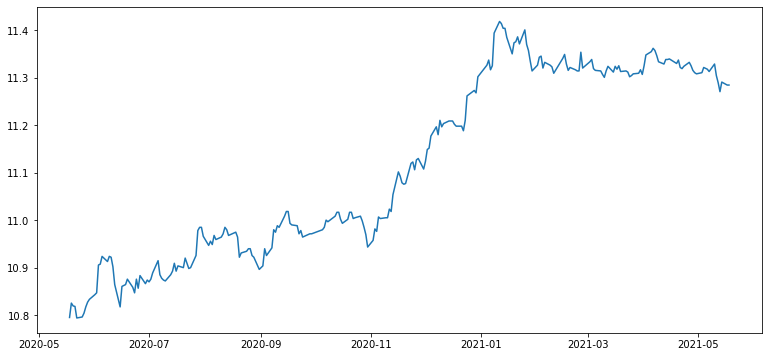

In [243]:
close_log = np.log(df_close)
plt.plot(close_log)

In [244]:
augmented_dickey_fuller_test(close_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


p-value 줄어듦

### 2. Moving average 제거 - 추세(Trend) 상쇄하기

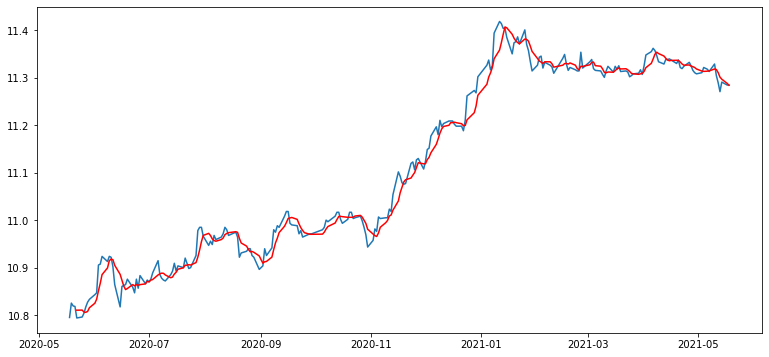

In [245]:
moving_avg_close = close_log.rolling(window=5).mean()  # moving average구하기 
plt.plot(close_log)
plt.plot(moving_avg_close, color='red')

In [246]:
ts_log_moving_avg_close = close_log - moving_avg_close # 변화량 제거
ts_log_moving_avg_close.head(15)

Date
2020-05-18         NaN
2020-05-19         NaN
2020-05-20         NaN
2020-05-21         NaN
2020-05-22   -0.016392
2020-05-25   -0.014548
2020-05-26   -0.002174
2020-05-27    0.011339
2020-05-28    0.019515
2020-05-29    0.017606
2020-06-01    0.018022
2020-06-02    0.013375
2020-06-03    0.054302
2020-06-04    0.040126
2020-06-05    0.038384
Name: Close, dtype: float64

In [247]:
# 결측치 제거
ts_log_moving_avg_close.dropna(inplace=True)
ts_log_moving_avg_close.head(15)

Date
2020-05-22   -0.016392
2020-05-25   -0.014548
2020-05-26   -0.002174
2020-05-27    0.011339
2020-05-28    0.019515
2020-05-29    0.017606
2020-06-01    0.018022
2020-06-02    0.013375
2020-06-03    0.054302
2020-06-04    0.040126
2020-06-05    0.038384
2020-06-08    0.013560
2020-06-09    0.009080
2020-06-10    0.004001
2020-06-11   -0.014952
Name: Close, dtype: float64

In [248]:
augmented_dickey_fuller_test(ts_log_moving_avg_close)

Results of Dickey-Fuller Test:
Test Statistic                -7.801633e+00
p-value                        7.466367e-12
#Lags Used                     1.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


### 3. 차분(Differencing) - 계절성(Seasonality) 상쇄하기

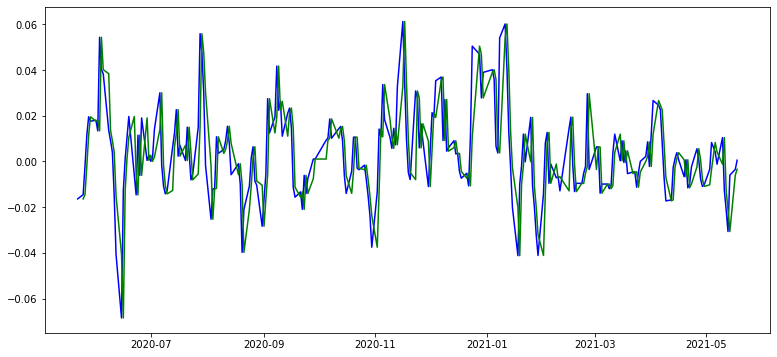

In [249]:
ts_log_moving_avg_shift = ts_log_moving_avg_close.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

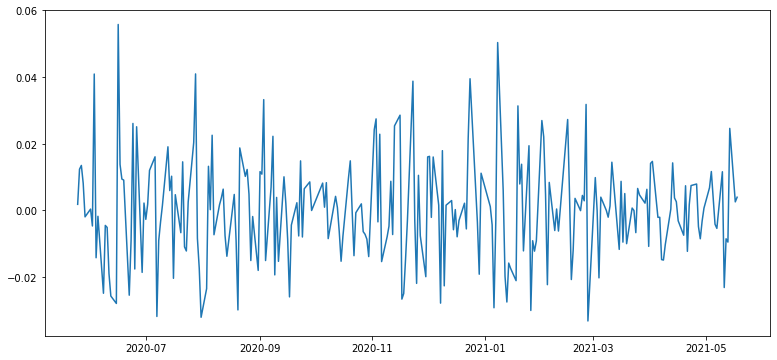

In [250]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

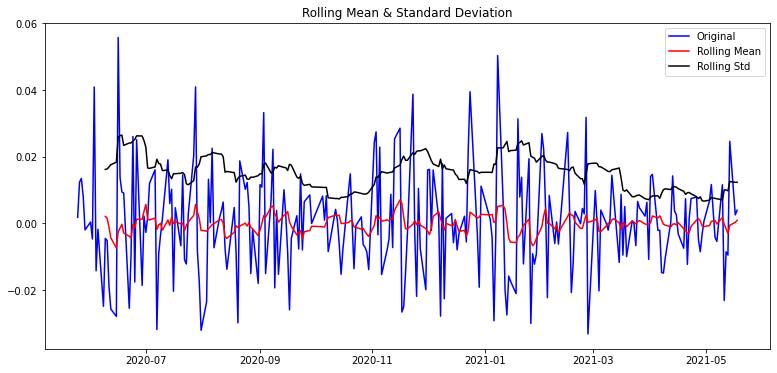

In [251]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [252]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -9.922422e+00
p-value                        2.966712e-17
#Lags Used                     5.000000e+00
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


- shift 함수는 데이터프레임 값을 한개씩 미룸 1이면 1씩 미루고 -1이면 1씩 앞당김

# 시계열 분해(Time series decomposition)

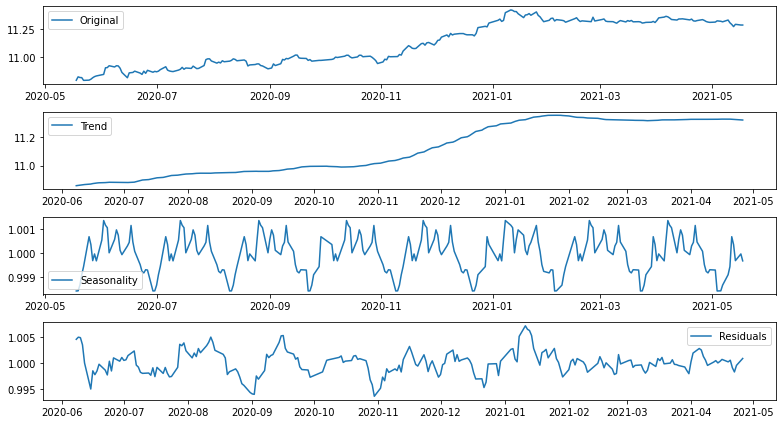

In [253]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(close_log, model='multiplicative', period = 30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(close_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

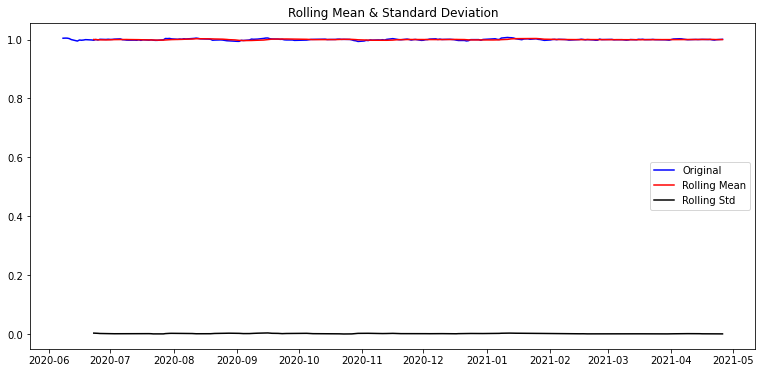

In [254]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [255]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


# ARIMA 모델의 정의


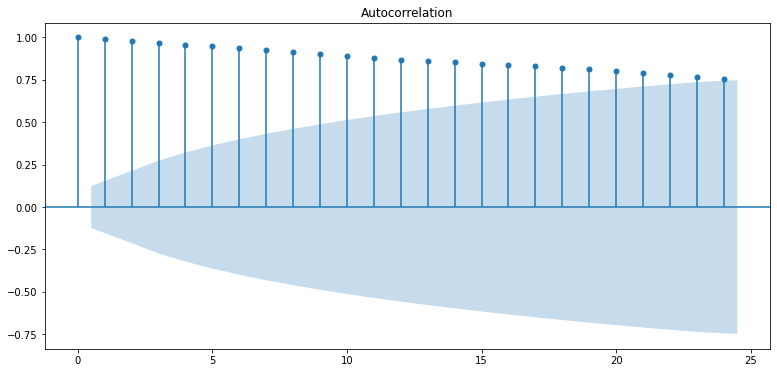

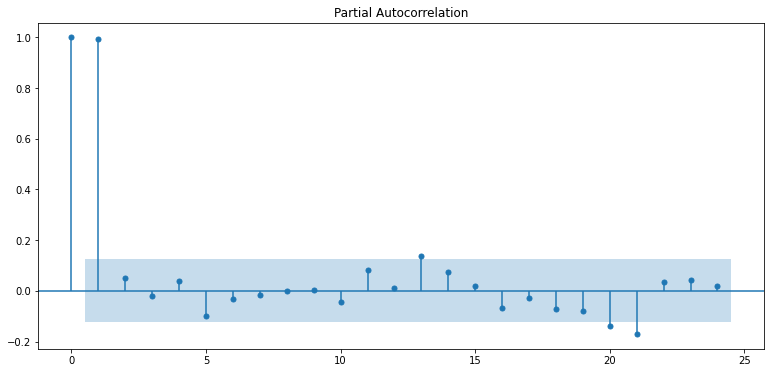

In [256]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(close_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(close_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


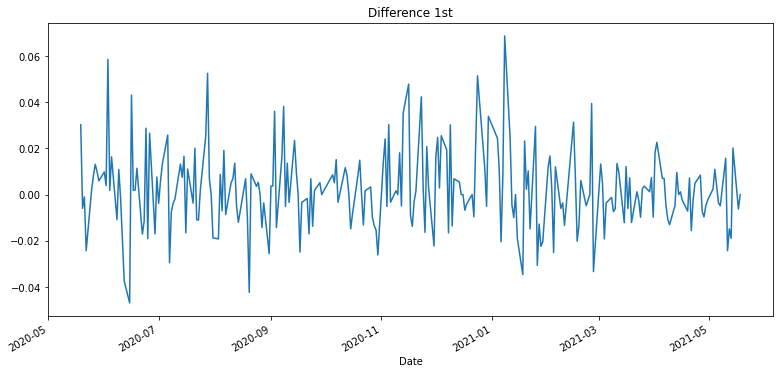

In [257]:
# 1차 차분 구하기
diff_1 = close_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 학습데이터 분리

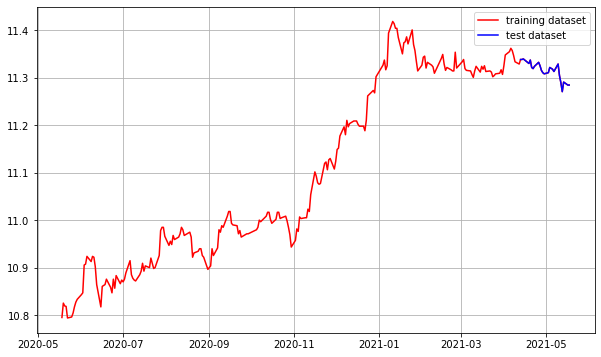

In [258]:
train_data, test_data = close_log[:int(len(close_log)*0.9)], close_log[int(len(close_log)*0.9):]
train_data_high, test_data_high = close_log[:int(len(high_log)*0.9)], close_log[int(len(high_log)*0.9):]
train_data_low, test_data_low = close_log[:int(len(low_log)*0.9)], close_log[int(len(low_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(close_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [259]:
print(close_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    10.795486
2020-05-19    10.825760
Name: Close, dtype: float64
(225,)
(25,)


In [260]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model_1 = ARIMA(train_data, order=(1, 1, 0))  

fitted_m1 = model_1.fit(disp=-1)    
print(fitted_m1.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Tue, 31 Aug 2021   AIC                          -1164.792
Time:                        14:39:01   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

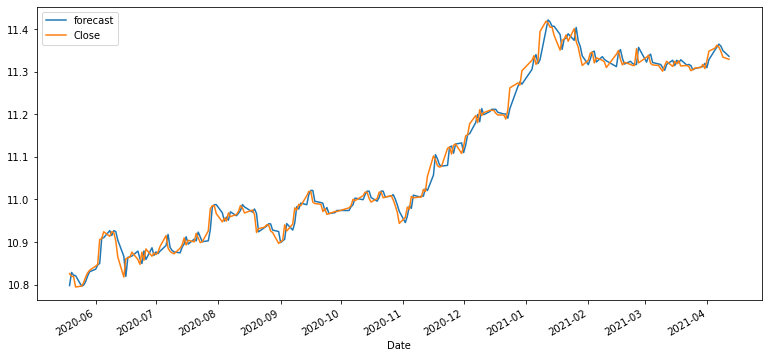

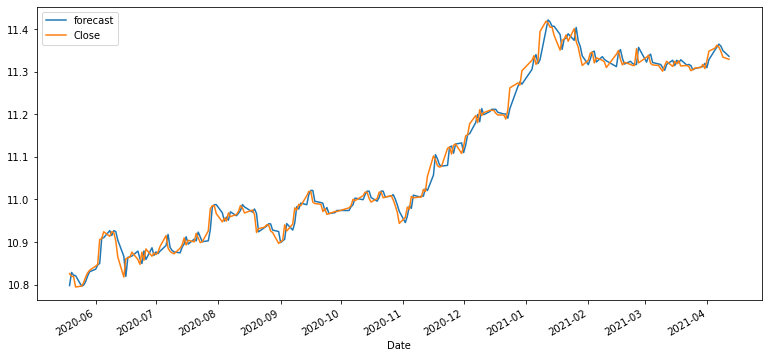

In [261]:
fitted_m1.plot_predict()

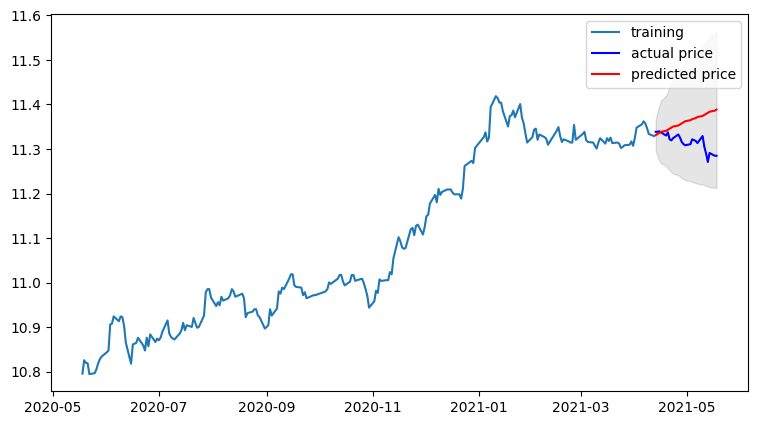

In [262]:
def prediction(fitted_m):
    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(9,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()

    return fc,se,conf

fc,se,conf = prediction(fitted_m1)

In [263]:
def summary(fc,se,conf):
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    import math

    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))
summary(fc,se,conf)

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


# 카카오 주식에 적용

## Load data

In [264]:
df = pd.read_csv("kakao.csv", index_col='Date', parse_dates=True)
df_close = df["Close"]
df_close

Date
2020-08-31     81400.0
2020-09-01     80300.0
2020-09-02     82400.0
2020-09-03     82000.0
2020-09-04     80400.0
                ...   
2021-08-25    151000.0
2021-08-26    149500.0
2021-08-27    150000.0
2021-08-30    151500.0
2021-08-31    155000.0
Name: Close, Length: 249, dtype: float64

## Time Series Stationary

In [265]:
def stationary(df_close):
    global close_log
    close_log = np.log(df_close) # 로그함수 변형

    moving_avg_close = close_log.rolling(window=5).mean()  # moving average구하기 
    ts_log_moving_avg_close = close_log - moving_avg_close # 변화량 제거


    ts_log_moving_avg_close.dropna(inplace=True) # 결측치 제거

    ts_log_moving_avg_shift = ts_log_moving_avg_close.shift() # 차분
    ts_log_moving_avg_diff = ts_log_moving_avg_close - ts_log_moving_avg_shift
    ts_log_moving_avg_diff.dropna(inplace=True)


    augmented_dickey_fuller_test(ts_log_moving_avg_diff)
stationary(df_close)

Results of Dickey-Fuller Test:
Test Statistic                -1.311490e+01
p-value                        1.606577e-24
#Lags Used                     3.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


# Split Data to train and test set

In [266]:
train_data, test_data = close_log[:int(len(close_log)*0.9)], close_log[int(len(close_log)*0.9):]
train_data_high, test_data_high = close_log[:int(len(high_log)*0.9)], close_log[int(len(high_log)*0.9):]
train_data_low, test_data_low = close_log[:int(len(low_log)*0.9)], close_log[int(len(low_log)*0.9):]

# Modeling / Predict

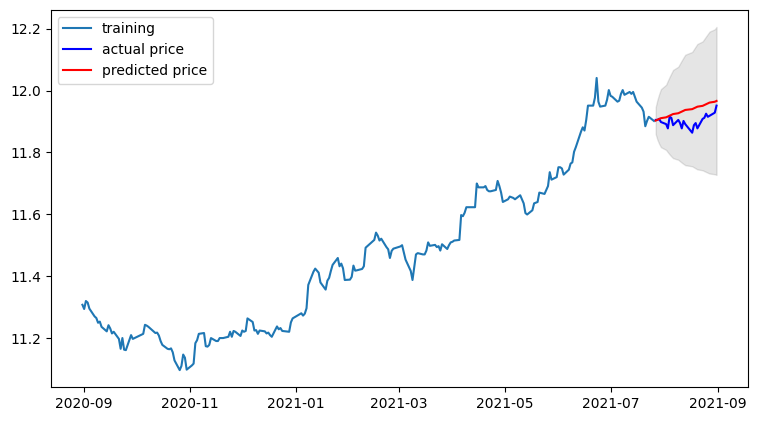

In [267]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model_1 = ARIMA(train_data, order=(1, 1, 0))  

fitted_m1 = model_1.fit(disp=-1)    
fc,se,conf = prediction(fitted_m1)

# Summarize

In [268]:
summary(fc,se,conf)

MSE:  33335083.243344303
MAE:  4896.5795838442145
RMSE:  5773.654236559746
MAPE: 3.34%


# 현대차 주식에 적용

## Load data

In [269]:
df = pd.read_csv("hyundai_motor.csv", index_col='Date', parse_dates=True)
df_close = df["Close"]
df_close

Date
2020-08-31    176500.0
2020-09-01    180000.0
2020-09-02    176000.0
2020-09-03    176500.0
2020-09-04    172500.0
                ...   
2021-08-25    209500.0
2021-08-26    210000.0
2021-08-27    208500.0
2021-08-30    210000.0
2021-08-31    212500.0
Name: Close, Length: 249, dtype: float64

## Time Series Stationary

In [270]:
def stationary(df_close):
    global close_log
    close_log = np.log(df_close) # 로그함수 변형

    moving_avg_close = close_log.rolling(window=5).mean()  # moving average구하기 
    ts_log_moving_avg_close = close_log - moving_avg_close # 변화량 제거


    ts_log_moving_avg_close.dropna(inplace=True) # 결측치 제거

    ts_log_moving_avg_shift = ts_log_moving_avg_close.shift() # 차분
    ts_log_moving_avg_diff = ts_log_moving_avg_close - ts_log_moving_avg_shift
    ts_log_moving_avg_diff.dropna(inplace=True)


    augmented_dickey_fuller_test(ts_log_moving_avg_diff)
stationary(df_close)

Results of Dickey-Fuller Test:
Test Statistic                -9.008866e+00
p-value                        6.203839e-15
#Lags Used                     7.000000e+00
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


# Split Data to train and test set

In [271]:
train_data, test_data = close_log[:int(len(close_log)*0.9)], close_log[int(len(close_log)*0.9):]
train_data_high, test_data_high = close_log[:int(len(high_log)*0.9)], close_log[int(len(high_log)*0.9):]
train_data_low, test_data_low = close_log[:int(len(low_log)*0.9)], close_log[int(len(low_log)*0.9):]

# Modeling / Predict

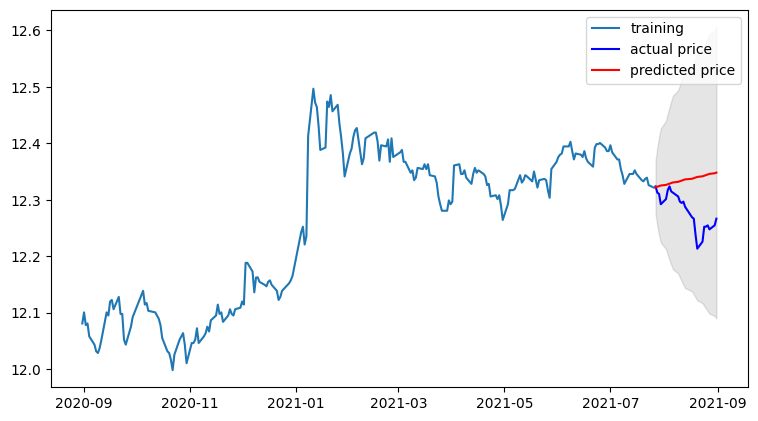

In [272]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model_1 = ARIMA(train_data, order=(1, 1, 0))  

fitted_m1 = model_1.fit(disp=-1)    
fc,se,conf = prediction(fitted_m1)

# Summarize

In [273]:
summary(fc,se,conf)

MSE:  208945513.6337782
MAE:  11857.899791981674
RMSE:  14454.94772158579
MAPE: 5.62%


# 결과

##  루브릭 문항
1. 시계열의 안정성이 충분히 확인되었는가?
    - 플로팅과 adfuller 메소드가 모두 적절히 사용되었음
    - 삼성전자, 카카오, 현대차 모두 함수로 만들어 적절히 사용함<br/><br/>

2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?
    - p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨
    - 차분은 1차 차분만 하여도 적절한 p value값이 나왔기에 모두  d = 1로 적용<br/><br/>

3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?
    - 3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨
    - 삼성전자 MAPE: 4.68%
    - 카카오 MAPE: 3.34%
    - 현대차 MAPE: 5.62%
    - 모두 만족